In [95]:
''' Implementation of Fast Fourier Transform (FFT), inverse FFT and Discrete Fourier Transform (DFT) '''
import sys
from math import log
import numpy as np
from scipy.fft import fftn,ifftn
from matplotlib import pyplot as plt
import cv2 as cv
import time
import timeit

In [96]:
def fftComplex(f,inverse=False):
    '''
    Implementation of Fast Fourier Transform and Inverse Fast Fourier Transform.
    Input : f            -> time series (1-D array)
            inverse      -> False, if FFT calculation
                            True, if inverse FFT calculation
    Output: outputSeries -> Fourier transform of f (in the complex number form), if inverse = False
                            Inverse Fourier transform of f, if inverse = True
    Assumption: Length of f is 2^k, where k is a positive integer. 
    '''
    N=len(f)                   # Length of the power series
    if N == 1:
        return f
    height=log(N,2)            # Getting the power of 2 of the length
    h=int(height)
    if height-h > 0:           # Checking if the dimension is a power of 2
        sys.exit("The dimensions of the series are not powers of 2")

    ## Decide epsilon based on if it is FFT function or inverse FFT
    if inverse == True:
        eps= np.e ** (1j*np.pi)# epsilon for inverse FT
    else:
        eps=np.e ** (-1j*np.pi)# epsilon for FT
    
    ## Arrange initial pairs to calculate fft
    tempSeries=[None for i in range(N)]
    for i in range(N):
        if tempSeries[i] is None:
            reverseBits=int(bin(i)[2:].zfill(h)[-1::-1],2)
            if i == reverseBits:
                tempSeries[i]=f[i]
            else:
                tempSeries[reverseBits]=f[i]
                tempSeries[i]=f[reverseBits]
        
    ## Calculate fft for pairs of higher orders until the wavelength of the series becomes equal to the input series
    tempSeries=np.vstack([tempSeries,[None for i in range(N)]]) # Add a row to tempSeries. Two rows of tempSeries store the 
                                                                # modified fft series in even and odd hiararchies alternately
    for m in range(1,h+1):
        waveLength=2**(m-1)
        w=eps**(2**(1-m))
  #      w=np.e ** (-1j*np.pi/waveLength)
        if m%2==1:
            inputSeries=tempSeries[0]
        else:
            inputSeries=tempSeries[1]
        outputSeries=[None for i in range(N)]
    
        for n in range(0,N,2*waveLength):
            for step in range(waveLength):
                outputSeries[n+step]=(inputSeries[n+step]+inputSeries[n+step+waveLength]*(w**step))
                outputSeries[n+step+waveLength]=(inputSeries[n+step]-inputSeries[n+step+waveLength]*(w**step))
            
        if m%2==1:
            tempSeries[1]=outputSeries
        else:
            tempSeries[0]=outputSeries
    
    return outputSeries    

In [97]:
def fftImage(img,inverse=False):
    '''
    Implementation of Fast Fourier Transform for a 2-D image.
    Input image: img (grey image)
                 inverse = False for FFT , img is a real grey image.
                           True for IFFT, img is a fourier image
    Output : oimg (fourier transform image with complex coefficients, if inverse = False
                   real image, if inverse = True)
    Assumption: Dimensions of input image is M x N, 
                where M and N are of the form 2^k, k is a positive integer.     
    ''' 
    for i in range(len(img)):
        rowFFT=fftComplex(img[i])
        if i == 0:
            oimg=rowFFT
        else:
            oimg=np.vstack([oimg,rowFFT])
    for i in range(len(oimg[0])):
        oimg[:,i]=fftComplex(oimg[:,i])
    
    if inverse == True:
        return np.real(oimg)
    return oimg

In [98]:
def createU(n,inverse=False):
    '''
    Create U matrix for DFT
    '''
    U=np.zeros((n,n),dtype=complex)
    if inverse == True:
        eps=np.e**(2j*np.pi/n)
    else:
        eps=np.e**(-2j*np.pi/n)
    
    for i in range(n):
        for j in range(n):
            U[i,j]=eps**(i*j)
    return (U/n)


In [99]:
def dftImage(img,inverse=False):
    '''
    Implementation of Discrete Fourier Transform for a 2-D image.
    Input image: img (grey image)
                 inverse = False for DFT , img is a real grey image.
                           True for IDFT, img is a fourier image
    Output     : oimg (fourier transform image with complex coefficients, if inverse = False
                       real image, if inverse = True)
    Assumption: Input image is a square image
    '''
    m,n=img.shape
    
    U=createU(n,inverse)
    if m == n:
        oimg=np.linalg.multi_dot([U,img,U])
    else:
        V=createU(m,inverse)
        oimg=np.linalg.multi_dot([V,img,U])

    return oimg

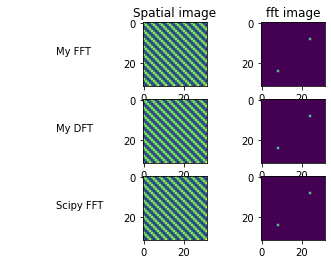

In [100]:
# Creation of image, that will be the input of Fast Fourier Transform implemented from scratch.

N=32

ff=np.zeros([N,N])
ff[N//4,N-N//4]=1
ff[N-N//4,N//4]=1

img=ifftn(ff)
img1=fftImage(ff,True) # Calculate inverse FFT using the implemented FFT function
img2=dftImage(ff,True) # Calculate IDFT using the implemented DFT function

# Apply scipy FFT on the image
x=fftn(img)

# Apply implemented FFT on the image
imgfft=fftImage(img1)

# Apply implemented DFT on the image
imgdft=dftImage(img2)

# Plot spatial image, implemented FFT image and the scipy FFT image. for comparison
plt.clf

plt.subplot(331)
plt.text(0.5,0.5,'My FFT')
plt.axis('off')

plt.subplot(334)
plt.text(0.5,0.5,'My DFT')
plt.axis('off')

plt.subplot(337)
plt.text(0.5,0.5,'Scipy FFT')
plt.axis('off')

plt.subplot(332)
plt.imshow(np.real(img1))
plt.title('Spatial image')

plt.subplot(335)
plt.imshow(np.real(img2))

plt.subplot(338)
plt.imshow(np.real(img))

plt.subplot(333)
plt.imshow(np.real(imgfft))
plt.title('fft image')

plt.subplot(336)
plt.imshow(np.real(imgdft))

plt.subplot(339)
plt.imshow(np.real(x))

plt.savefig("FFT.jpg")